# Import environment

In [1]:
import os
from datetime import datetime
import pathlib


if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import (
    load_exp_config, 
    get_value_from_fields, 
    )

from utils.load_data import (
    get_df_from_datetime_range
    )

from utils.plotting import (
    STICK_SIZE,
    plot_cost_ic_learning_curve_mod,
    plot_cost_median_mod_learning_curve,
    plot_cost_median_top_5_learning_curve,
    plot_accum_cost_ic,
    plot_accum_cost_median,
    plot_chosen_best_checkpoint,
    plot_distance_goal_hist
    )

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# plt.style.use("tableau-colorblind10")
plt.style.use("seaborn-v0_8-whitegrid")

from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

%matplotlib inline

In [2]:
try:
    from src.objective import ThreeWheeledRobotCostWithSpot
except:
    from src.objective import ThreeWheeledRobotCostWithSpot

# Setup Objective function for re-calculation

In [3]:

objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

objective_function = ThreeWheeledRobotCostWithSpot(
    quadratic_model=ModelQuadLin(
        weights= [100, 100, 0, 0, 0],
        quad_matrix_type="diagonal",
        is_with_linear_terms=False),
        spot_gain=500,
        spot_x_center=-1.5,
        spot_y_center=-1.5,
        spot_std=0.2,
    )


def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

    

In [4]:

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

200.0

## Plot objective

In [15]:
def get_cost_map(x_lim, y_lim):
    X = np.arange(x_lim[0], x_lim[1], 0.01)
    Y = np.arange(y_lim[0], y_lim[1], 0.01)

    X, Y = np.meshgrid(X, Y)
    Z = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z.append(objective_function(observation=np.array([[X[i, j], Y[i, j], 0]]),
                                        action=np.array([[0, 0]])))

    Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
    
    return X, Y, Z

X, Y, Z = get_cost_map([-3, 0.3], [-3, 0.3])

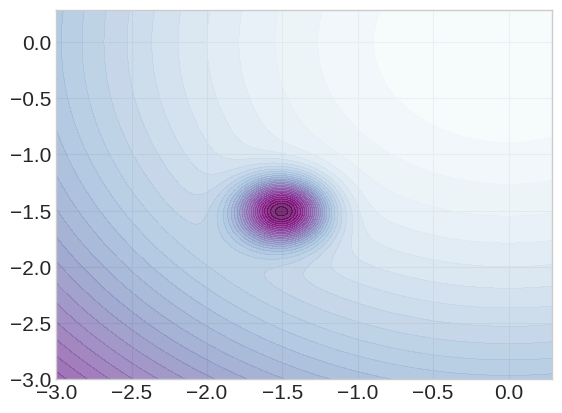

In [16]:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, Z, alpha=0.8, levels=35, cmap="BuPu")
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

# Plotting

## Get data from experiments

In [17]:
DECAY_RATE = 1

end_datetime_str = start_datetime_str = "2024-10-15 11-12-50"
stanley_df = get_df_from_datetime_range(start_datetime_str, 
                                        end_datetime_str, 
                                        objective_function=objective_function,
                                        decay_rate=DECAY_RATE)

In [18]:
DECAY_RATE = 1

# start_datetime_str = "2024-09-20 11-53-51" 
# end_datetime_str = "2024-09-20 15-48-40"
# start_datetime_str = "2024-10-02 16-28-50"s
# end_datetime_str = "2024-10-04 08-55-00"

start_datetime_str = "2024-10-15 17-20-00"
end_datetime_str = "2024-10-16 02-56-46"
calf_df = get_df_from_datetime_range(start_datetime_str, 
                                     end_datetime_str, 
                                     objective_function=objective_function,
                                     decay_rate=DECAY_RATE,
                                     max_iter=np.inf,
                                     reload=True)

calf_df.head() 

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],steering angle [rad],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,absolute_path,objective_value,accumulative_objective,experiment_path
0,0.000,180.000000,1800.000000,1,1,0.499996,-0.000319,-3.000000,-3.000000,0.000100,1,8343.740302,8343.750303,1800.000001,14400.000008,-0.010000,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1800.000000,180.000000,/home/tcc/huyhoang/qcar-regelum-playground/reg...
1,0.518,355.406157,1754.061573,1,1,0.500000,-0.000212,-2.922622,-2.999816,0.000665,1,8343.740281,8343.740302,1754.061616,14032.492931,-0.000021,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1754.061479,355.406148,/home/tcc/huyhoang/qcar-regelum-playground/reg...
2,1.020,526.030606,1706.244486,1,1,0.500000,-0.000142,-2.839681,-2.999776,0.000447,1,8343.740271,8343.740281,1706.244505,13649.956043,-0.000010,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1706.244439,526.030592,/home/tcc/huyhoang/qcar-regelum-playground/reg...
3,1.522,692.025874,1659.952685,1,1,0.500000,0.000272,-2.756936,-2.999805,-0.000854,1,8343.740261,8343.740271,1659.952757,13279.622055,-0.000010,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1659.952759,692.025868,/home/tcc/huyhoang/qcar-regelum-playground/reg...
4,2.108,852.653886,1606.280118,1,1,0.499999,0.000553,-2.657720,-2.999887,-0.001738,1,8343.730258,8343.740261,1606.280417,12850.243335,-0.010003,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1606.280088,852.653877,/home/tcc/huyhoang/qcar-regelum-playground/reg...


## Define colors

In [19]:
color_selection = {
    "CALF": ["lightblue", "tab:blue"],
    "Stanley": ["tab:red"],
}

## Plot learning curves

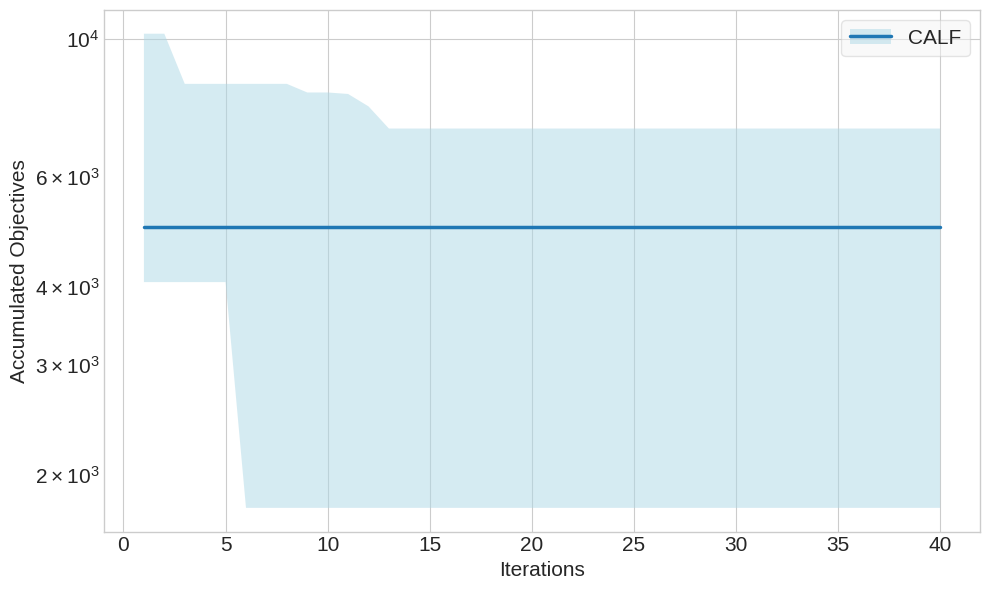

In [20]:
# %matplotlib inline
plt.clf()

MEDIUM_SIZE = 10
BIG_SIZE = 15
plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=BIG_SIZE)
plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)

plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p3 = plot_cost_ic_learning_curve_mod(calf_df, ax,
                                     low_quantile=0.025, high_quantile=0.975, 
                                     color=color_selection["CALF"][0], 
                                     use_interpolate=True)
p4 = plot_cost_median_mod_learning_curve(calf_df, ax, color=color_selection["CALF"][1])

# p6 = ax.axhline(y=stanley_df.accumulative_objective.values[-1], color=color_selection["Stanley"][0], linestyle="solid")


legend_info = {
    "CALF": (p3, p4),
    # "Stanley": p6
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5)
legend.set_frame_on(True)

ax.set_yscale("log")
# ax.set_xlim(0, 40)
# ax.set_ylim(5000, 10000)
plt.tight_layout()
fig.savefig("media/report_learning_curves.svg", 
            facecolor='w',
            bbox_inches = 'tight',
            pad_inches = 0)

## Plot accumulated cost over time

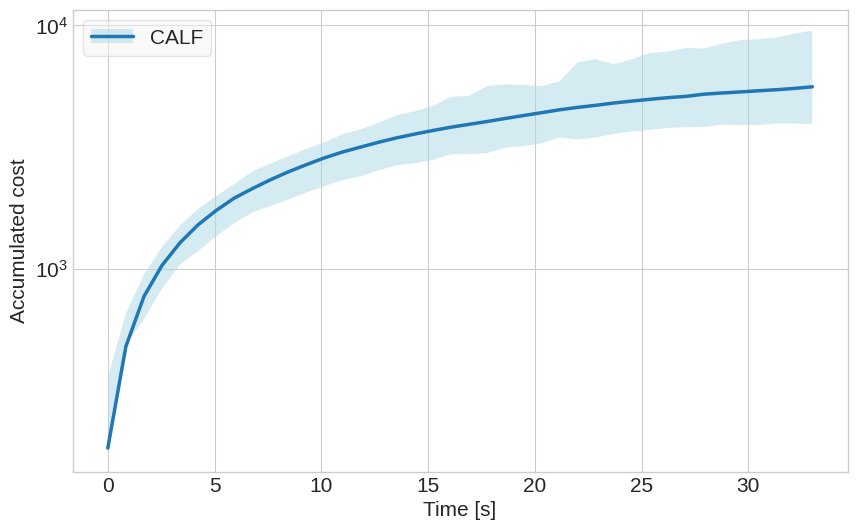

In [21]:
# %matplotlib inline

plt.clf()
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
# ax.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p3 = plot_accum_cost_ic(calf_df, ax, color=color_selection["CALF"][0])
p4 = plot_accum_cost_median(calf_df, ax, color=color_selection["CALF"][1])

# p6 = plot_accum_cost_median(stanley_df, ax, color=color_selection["Stanley"][0])


legend_info = {
    "CALF": (p3, p4),
    # "Stanley": p6
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5)
legend.set_frame_on(True)

ax.set_yscale("log")
# ax.set_xlim(0, 40)

ax.set_ylabel("Accumulated cost")

ax.tick_params(axis='both', labelsize=STICK_SIZE)

fig.savefig("media/report_acc_costs.svg", 
            facecolor="white",
            bbox_inches = 'tight',
            pad_inches = 0)
# plt.show()
# frame

# Plot trajectories

1. Find the best checkpoint of CALF, SARSA_m, PPO
2. Run the best checkpoints with 25 seeds
3. Plot each of them in 1 subplot and with Nominal, 3x MPC

## Find the best CALF and Control signal

In [22]:
calf_df
calf_df["goal_err"] = calf_df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)

group_df = calf_df.groupby(["absolute_path"]).last()
group_df = group_df[group_df.goal_err < 2]
id = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index
id
calf_df.query(f"absolute_path == \"{id[0]}\"")
# calf_df.absolute_path == id[0]



,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],steering angle [rad],x [m],y [m],angle [rad],...,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,absolute_path,objective_value,accumulative_objective,experiment_path,goal_err
0,0.000,180.000000,1800.000000,1,6,0.500000,-9.253582e-05,-3.000000,-3.000000,0.000100,...,11678.155753,11678.164956,1800.000001,14400.000008,-0.009203,/home/tcc/huyhoang/qcar-regelum-playground/reg...,1800.000000,180.000000,/home/tcc/huyhoang/qcar-regelum-playground/reg...,4.242641
1,0.745,188.783864,87.838637,1,6,0.169638,-1.700000e+00,-0.910417,-0.205891,0.844722,...,1267.845659,11678.155753,158.480614,1267.844914,-10410.310094,/home/tcc/huyhoang/qcar-regelum-playground/reg...,87.125081,188.712508,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.933408
2,1.626,195.592836,68.089725,1,6,0.292476,-3.324336e-01,-0.814888,-0.098519,0.845516,...,1064.407404,11678.155753,138.864589,1110.916708,-10613.748349,/home/tcc/huyhoang/qcar-regelum-playground/reg...,67.374832,195.449991,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.820822
3,2.353,201.701612,61.087761,1,6,0.121567,-1.700000e+00,-0.774629,-0.067547,0.791555,...,984.938323,1064.407404,123.117152,984.937219,-79.469080,/home/tcc/huyhoang/qcar-regelum-playground/reg...,60.461204,201.496112,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.777568
4,3.125,206.933279,52.316670,1,6,0.106192,-1.700000e+00,-0.719028,-0.019685,0.760122,...,1131.331646,1064.407404,109.517457,876.139656,66.924242,/home/tcc/huyhoang/qcar-regelum-playground/reg...,51.738885,206.670000,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.719297
5,4.178,211.575314,46.420348,1,6,0.098981,-1.700000e+00,-0.677778,0.004325,0.692905,...,1064.395288,1064.407404,93.951936,751.615485,-0.012116,/home/tcc/huyhoang/qcar-regelum-playground/reg...,45.940229,211.264023,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.677792
6,5.585,215.587584,40.122696,1,6,0.092274,-1.580852e+00,-0.629996,0.025769,0.605600,...,1064.394703,1064.407404,76.431101,611.448810,-0.012701,/home/tcc/huyhoang/qcar-regelum-playground/reg...,39.755946,215.239618,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.630523
7,6.504,219.225506,36.379223,1,6,0.088483,-1.490694e+00,-0.599491,0.037015,0.550700,...,1064.394963,1064.407404,66.403026,531.224208,-0.012441,/home/tcc/huyhoang/qcar-regelum-playground/reg...,36.075951,218.847213,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.600633
8,7.532,222.504332,32.788256,1,6,0.084680,-1.397485e+00,-0.568486,0.047053,0.499246,...,564.556295,1064.407404,57.463663,459.709305,-499.851109,/home/tcc/huyhoang/qcar-regelum-playground/reg...,32.539012,222.101114,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.570430
9,8.931,225.328360,28.240279,1,6,0.079684,-1.267584e+00,-0.526403,0.058429,0.434629,...,580.118025,1064.407404,46.941649,375.533191,-484.289379,/home/tcc/huyhoang/qcar-regelum-playground/reg...,28.051379,224.906252,/home/tcc/huyhoang/qcar-regelum-playground/reg...,0.529635


/home/tcc/huyhoang/qcar-regelum-playground/regelum_data/outputs/2024-10-15/17-23-41/0/.callbacks/CALFHistoricalDataCallback/observations_actions_it_00006.h5


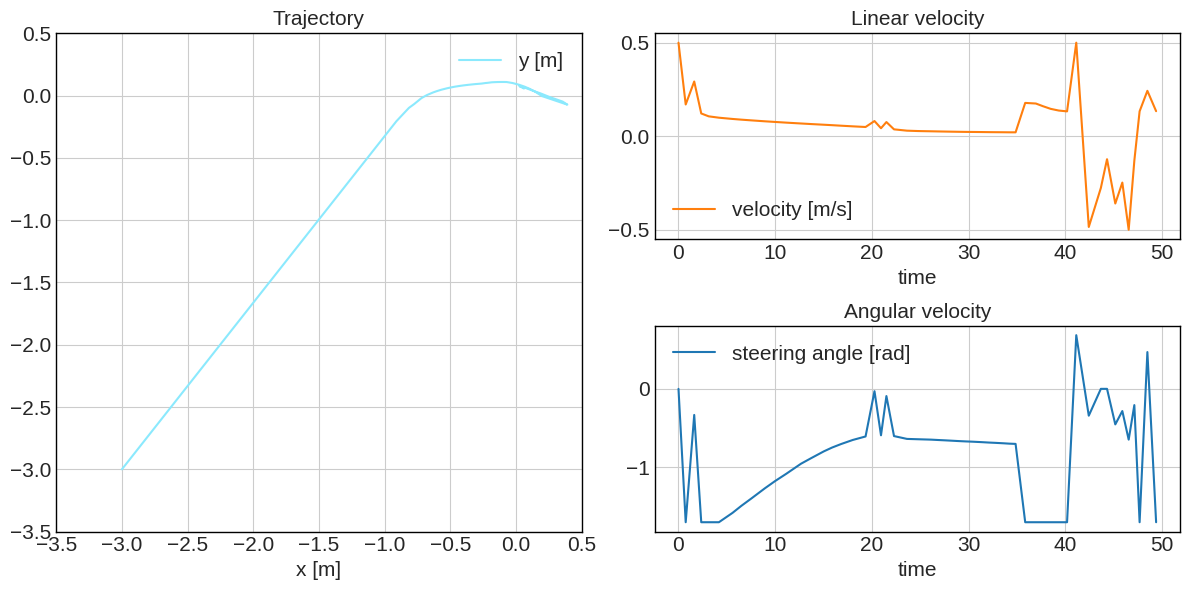

In [39]:
def find_best_exp_from_df(df, radius=2):
    df["goal_err"] = df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)

    group_df = df.groupby(["absolute_path"]).last()
    group_df = group_df[group_df.goal_err < radius]

    index = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index
    best_exp = df.query(f"absolute_path == \"{index[0]}\"")

    return best_exp, index[0]

best_calf_df, best_calf_path = find_best_exp_from_df(calf_df, radius=2)

print(best_calf_path)

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
best_calf_df.plot(x="x [m]", y="y [m]", title="Trajectory", ax=ax1)
ax1.set_ylim(-3.5, 0.5)
ax1.set_xlim(-3.5, 0.5)

ax2 = plt.subplot(2, 2, 2)
best_calf_df.plot(x="time", 
                  y="velocity [m/s]", ax=ax2, color="tab:orange", title="Linear velocity")

ax3 = plt.subplot(2, 2, 4)
best_calf_df.plot(x="time", 
                  y="steering angle [rad]", ax=ax3, color="tab:blue", title="Angular velocity")
plt.tight_layout()

In [44]:
# def check_if_falling_case(df, sampling_time=0.1, max_linear_vel=1.2):


# best_calf_df.apply(lambda row: (row["x [m]"], row["x [y]"]), axis=1)

def validity_check(df):
    old_position = None
    old_timestamp = 0
    for idx, data in df.iterrows():
        position = np.array([data["x [m]"], data["y [m]"]])
        if old_position is not None:
            position_change = np.linalg.norm(position - old_position)
            delta_t = data["time"] - old_timestamp
            # print(position_change)
            if (position_change > delta_t*df["velocity [m/s]"].abs().max()):
                print("At", data["time"], position_change)
                return False

        old_timestamp = data["time"]
        old_position = position

    return True

print(validity_check(best_calf_df))
best_calf_df["velocity [m/s]"].max()

At 0.7450000000000045 3.4890404336631966
False


0.5

## Load Runs with best checkpoints

In [25]:
# CALF with spot penalty 1e2
# start_datetime_str = "2024-09-20 11-53-51"
# end_datetime_str = "2024-09-20 15-48-40"
best_calf_df = get_df_from_datetime_range(start_datetime_str, 
                                          end_datetime_str,
                                          objective_function=objective_function, 
                                          decay_rate=DECAY_RATE)


## Plotting trajectories functions

## Plotting trajectories

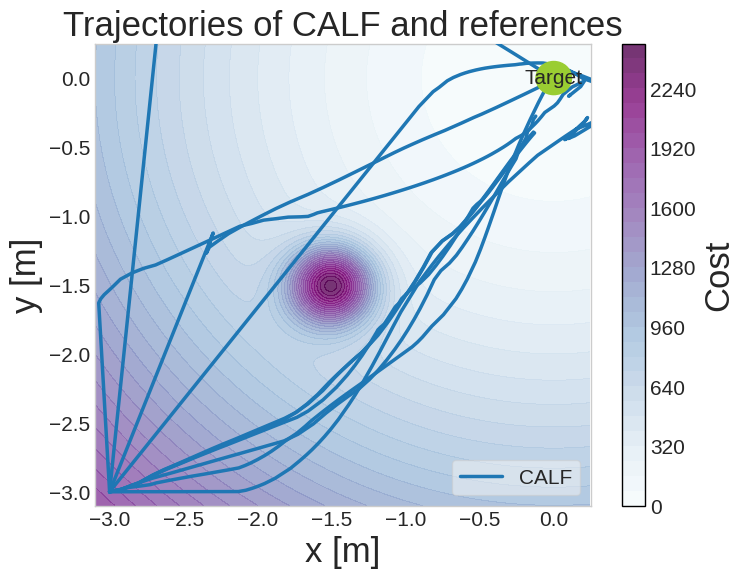

In [26]:
group_df = best_calf_df.groupby(["absolute_path"]).last()
top_10_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:10, :].index
top_10_df = best_calf_df[best_calf_df["absolute_path"].isin(top_10_abs_path)]
plot_chosen_best_checkpoint(top_10_df, "CALF", 
                            color_selection["CALF"][1], 
                            linestyle="solid", 
                            target_r=0.12,
                            get_cost_map_func=get_cost_map,
                            y_lim=[-3.1, 0.25],
                            x_lim=[-3.1, 0.25])

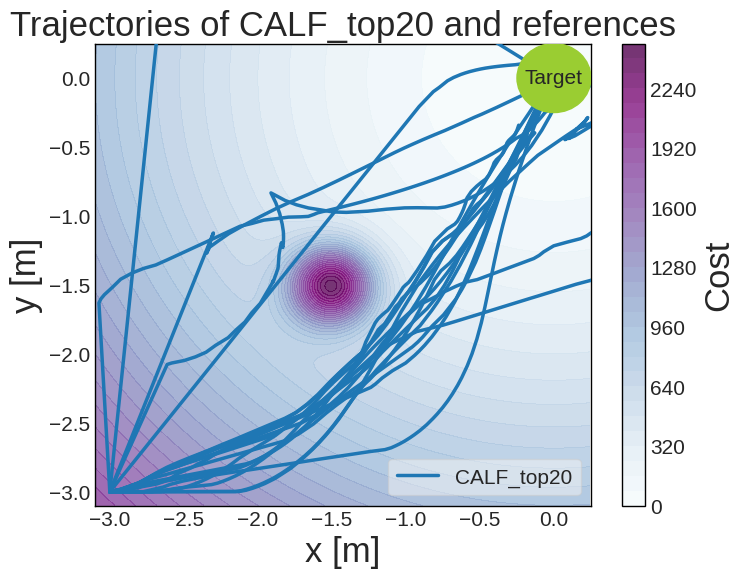

In [27]:
N_TOP=20
group_df = best_calf_df.groupby(["absolute_path"]).last()
top_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:N_TOP, :].index
top_df = best_calf_df[best_calf_df["absolute_path"].isin(top_abs_path)]
plot_chosen_best_checkpoint(top_df, f"CALF_top{N_TOP}", 
                            color_selection["CALF"][1], 
                            linestyle="solid", 
                            target_r=0.25,
                            get_cost_map_func=get_cost_map,
                            y_lim=[-3.1, 0.25],
                            x_lim=[-3.1, 0.25])

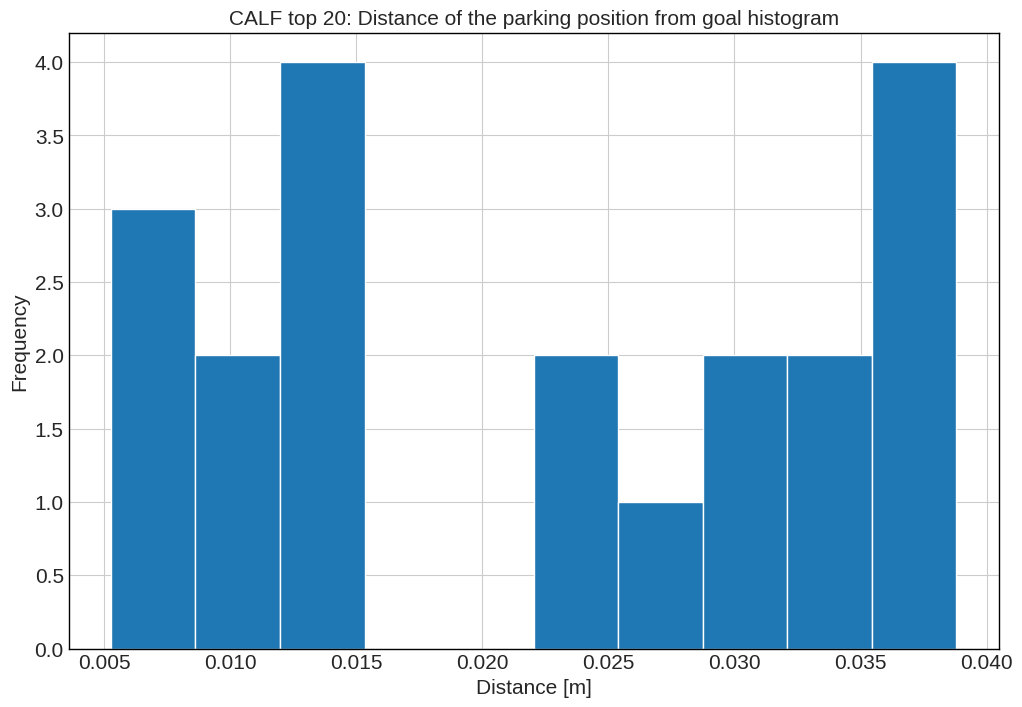

In [28]:
   
plot_distance_goal_hist(best_calf_df, "CALF", color_selection["CALF"][1], n_top=20)